In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
files = {
    'trp_revenue': 'TRP_VENITURI.xlsx',
    'permits': 'building_permitsVALORI.xlsx',
    'constr': 'Construction_index_anual.xlsx',
    'capex': 'ch_cu_investitii.xlsx'
}
dfs = {}
for key, file in files.items():
    try:
        dfs[key] = pd.read_excel(file)
    except FileNotFoundError as e:
        print(f"Error: Could not find file '{file}'. {e}")
        exit()
permits = dfs['permits'][['Year', 'Number of Building Permits']].copy()
permits.columns = ['Year', 'Total_Permits']
permits_annual = permits.set_index('Year').sort_index()
# Create lagged permits (previous year) as predictor
permits_annual['Permits_Lag1'] = permits_annual['Total_Permits'].shift(1)
constr_df = dfs['constr'].set_index('Year').sort_index()
# Standardize column name
if '%change' in constr_df.columns:
    constr_df = constr_df.rename(columns={'%change': 'Construction_Index'})
else:
    constr_df.columns = ['Construction_Index']
capex_df = dfs['capex'].set_index('Year').sort_index()
capex_df = capex_df.iloc[:, 0].to_frame(name='Govt_Capex')
col_revenue_name = 'Millions RON'
trp_revenue = dfs['trp_revenue']
if col_revenue_name in trp_revenue.columns:
    trp_revenue[col_revenue_name] = (
        trp_revenue[col_revenue_name]
        .astype(str).str.replace(' ', '').astype(float)
    )
    revenue_df = trp_revenue[['Year', col_revenue_name]].set_index('Year').sort_index()
else:
    print(f"Column '{col_revenue_name}' not found in {files['trp_revenue']}")
    exit()
df = revenue_df.join(permits_annual[['Permits_Lag1']], how='inner')
df = df.join(constr_df, how='inner')
df = df.join(capex_df, how='inner')
df_clean = df.dropna()

In [3]:
X = df_clean[['Permits_Lag1', 'Construction_Index', 'Govt_Capex']]
y = df_clean['Millions RON']
model = LinearRegression()
model.fit(X, y)
r2_train = model.score(X, y)
last_year = df_clean.index.max()
next_year = last_year + 1

In [4]:
try:
    val_permits_lag = permits_annual.loc[last_year, 'Total_Permits']
    val_index_next = constr_df.loc[next_year, 'Construction_Index']
    val_capex_next = capex_df.loc[next_year, 'Govt_Capex']
    X_next = pd.DataFrame([[val_permits_lag, val_index_next, val_capex_next]],
                          columns=['Permits_Lag1', 'Construction_Index', 'Govt_Capex'])
    pred_next = model.predict(X_next)[0]
    pred_msg = f"{pred_next:,.0f} RON"
except KeyError as e:
    pred_msg = f"Cannot predict {next_year}: Missing data for {e}"
    pred_next = np.nan

In [5]:
permits_last = permits_annual.loc[last_year, 'Total_Permits']
permits_next = permits_annual.loc[next_year, 'Total_Permits'] if next_year in permits_annual.index else np.nan

In [6]:
if not np.isnan(permits_next):
    permits_change_pct = ((permits_next - permits_last) / permits_last) * 100
    trend_desc = "INCREASED" if permits_change_pct > 0 else "DECREASED"
else:
    permits_change_pct = None
    trend_desc = "Unknown"

In [7]:
print("=" * 60)
print("TERAPLAST INSTALLATION SEGMENT REVENUE MODEL")
print(f"  Training RÂ² = {r2_train:.2f}")
print("âš  Note: CV RÂ² is not reported due to very small dataset.")
print("=" * 60)
print(f"{next_year} Market Drivers:")
print(f"  - Construction Volume: {val_index_next if 'val_index_next' in locals() else 'N/A'}")
print(f"  - Permits (Last Year Lag): {val_permits_lag if 'val_permits_lag' in locals() else 'N/A'}")
print(f"  - Govt Investment: {val_capex_next if 'val_capex_next' in locals() else 'N/A'} Billion RON")
print("-" * 60)
print(f"PREDICTION FOR {next_year} REVENUE: {pred_msg}")
print("-" * 60)
if trend_desc != "Unknown":
    print(f"Future Signal (for {next_year + 1}):")
    print(f"  Permits in {next_year} have {trend_desc} by {abs(permits_change_pct):.1f}% vs {last_year}.")
    if trend_desc == "DECREASED":
        print(f"  âš  WARNING: Fewer permits suggests potential revenue SLOWDOWN in {next_year + 1}.")
    else:
        print(f"  POSITIVE: More permits suggests demand continuing into {next_year + 1}.")
print("=" * 60)

TERAPLAST INSTALLATION SEGMENT REVENUE MODEL
  Training RÂ² = 0.45
âš  Note: CV RÂ² is not reported due to very small dataset.
2025 Market Drivers:
  - Construction Volume: 176.6
  - Permits (Last Year Lag): 36206
  - Govt Investment: 138.2 Billion RON
------------------------------------------------------------
PREDICTION FOR 2025 REVENUE: 670,778,135 RON
------------------------------------------------------------
Future Signal (for 2026):
  Permits in 2025 have INCREASED by 2.9% vs 2024.
  POSITIVE: More permits suggests demand continuing into 2026.


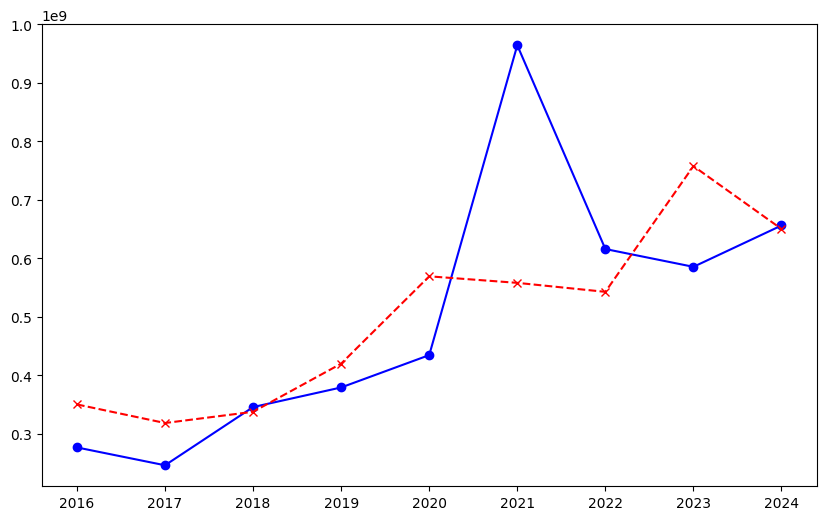

In [8]:
y_pred = model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(df_clean.index, y, marker='o', label='Actual Revenue', color='blue')
plt.plot(df_clean.index, y_pred, marker='x', linestyle='--', label='Predicted Revenue', color='red')